# Basic Data Analysis of jsPsych Stroop Experiment

This notebook shows you can analyze the data collected from a `psiTurk` experiment.  In this case we will analyze the data from the basic [jsPsych](http://www.jspsych.org) Stroop experiment which is shared in the [experiment exchange](http://psiturk.org/ee/Vn8uJAA2RGCSJp6pAoFgTH).  The basic format of the notebook is based on the Jupyter notebook tutorial from Jess Hamrick at the Data on the Mind workshop 2017.

## Loading Data

The first thing we need to do is to actually load our data.  Typically you might host your data in a MySQL database in some remote location (up to you) but in this example we are doing to use the simple SQLite solution that most experiments in `psiTurk` are configured to use by default.

In [184]:
import pandas as pd
import sqlite3
import json

# Read sqlite query results into a pandas DataFrame
con = sqlite3.connect("participants.db")
df = pd.read_sql_query("SELECT * from turkdemo", con)
con.close()

# verify that result of SQL query is stored in the dataframe
df.head()

,uniqueid,assignmentid,workerid,hitid,ipaddress,browser,platform,language,cond,counterbalance,codeversion,beginhit,beginexp,endhit,bonus,status,datastring
0,debugF52I9A:debugRB4SLX,debugRB4SLX,debugF52I9A,debug2H79P7,127.0.0.1,safari,macos,UNKNOWN,0,0,1.0,2017-06-27 12:16:30.072183,None,2017-06-27 12:17:12.614124,1.0,3,"{""condition"":0,""counterbalance"":0,""assignmentI..."
1,debugG8X84I:debugXZ51MU,debugXZ51MU,debugG8X84I,debugU9733I,127.0.0.1,safari,macos,UNKNOWN,0,0,1.0,2017-06-27 12:17:27.756568,None,2017-06-27 12:18:10.326320,1.0,3,"{""condition"":0,""counterbalance"":0,""assignmentI..."
2,debugUNVUKJ:debug7HGX36,debug7HGX36,debugUNVUKJ,debugIXM4GP,127.0.0.1,safari,macos,UNKNOWN,0,0,1.0,2017-06-27 12:18:20.164248,None,2017-06-27 12:18:54.532338,1.0,3,"{""condition"":0,""counterbalance"":0,""assignmentI..."
3,debugN92K5P:debug0H38PC,debug0H38PC,debugN92K5P,debugXLYQ4V,127.0.0.1,safari,macos,UNKNOWN,0,0,1.0,2017-06-27 12:19:04.105291,None,2017-06-27 12:19:39.220933,1.0,3,"{""condition"":0,""counterbalance"":0,""assignmentI..."
4,debugF9AUUZ:debug38B2FD,debug38B2FD,debugF9AUUZ,debugYNUPHU,127.0.0.1,safari,macos,UNKNOWN,0,0,1.0,2017-06-27 12:19:48.429272,None,None,0.0,1,None


The data structure from psiTurk is pretty scary.  It is not "tidy".  But it is highly reducdant and includes lots of relevant information about participants in your study.  Most of the data frame columns at this stage describe general things about each participant (e.g., when they began the hit, when they ended the hit, when they began the experiment, the value of their bonus, etc...).  The `datastring` column includes a JSON representation of the actual data collected in the experiment and so we first have to parse this string before it is useful.

## Parse JSON datastring

The first thing you want to do is remove subjects who do not have a valid datastring or who's status is below 3.  The status variable indicates how far into the experiment a participant has gotten (see [this link for full list of status codes](https://github.com/NYUCCL/psiTurk/blob/master/psiturk/experiment.py#L50)).  3 or greater currently means that they completed the task and so their data is probably safe to analyze.

In [186]:
# remove subjects where the data string is empty or status is below 3
dfclean=df.query("datastring == datastring and status>=3")
dfclean.head()

,uniqueid,assignmentid,workerid,hitid,ipaddress,browser,platform,language,cond,counterbalance,codeversion,beginhit,beginexp,endhit,bonus,status,datastring
0,debugF52I9A:debugRB4SLX,debugRB4SLX,debugF52I9A,debug2H79P7,127.0.0.1,safari,macos,UNKNOWN,0,0,1.0,2017-06-27 12:16:30.072183,None,2017-06-27 12:17:12.614124,1.0,3,"{""condition"":0,""counterbalance"":0,""assignmentI..."
1,debugG8X84I:debugXZ51MU,debugXZ51MU,debugG8X84I,debugU9733I,127.0.0.1,safari,macos,UNKNOWN,0,0,1.0,2017-06-27 12:17:27.756568,None,2017-06-27 12:18:10.326320,1.0,3,"{""condition"":0,""counterbalance"":0,""assignmentI..."
2,debugUNVUKJ:debug7HGX36,debug7HGX36,debugUNVUKJ,debugIXM4GP,127.0.0.1,safari,macos,UNKNOWN,0,0,1.0,2017-06-27 12:18:20.164248,None,2017-06-27 12:18:54.532338,1.0,3,"{""condition"":0,""counterbalance"":0,""assignmentI..."
3,debugN92K5P:debug0H38PC,debug0H38PC,debugN92K5P,debugXLYQ4V,127.0.0.1,safari,macos,UNKNOWN,0,0,1.0,2017-06-27 12:19:04.105291,None,2017-06-27 12:19:39.220933,1.0,3,"{""condition"":0,""counterbalance"":0,""assignmentI..."
5,debugTW8Q9O:debugOIJTEG,debugOIJTEG,debugTW8Q9O,debugOO2E3X,127.0.0.1,safari,macos,UNKNOWN,0,0,1.0,2017-06-27 12:20:27.501480,None,2017-06-27 12:20:55.747086,1.0,3,"{""condition"":0,""counterbalance"":0,""assignmentI..."


It turns out one subject was excluded here for not having data.  Next we want to obtain the data from the experiment out of the JSON column.  It takes a little bit of simple data munging to get it into a tidy data format:

In [187]:
def getTrialDataDF(data):
    tmp=pd.DataFrame(data['data'])
    tmp=tmp.join(pd.DataFrame(tmp['trialdata'].tolist()))
    tmp.drop('trialdata', 1)
    return tmp

stdf = dfclean['datastring'].apply(json.loads)
finaldata = pd.concat([getTrialDataDF(i) for i in stdf])
finaldata.head()

,current_trial,dateTime,trialdata,uniqueid,color,condition,congruence,correct_response,counterbalance,internal_node_id,key_press,rt,stimulus,time_elapsed,trial_index,trial_type,uniqueId,word
0,0,1498590992040,"{u'rt': 1643, u'trial_type': u'text', u'counte...",debugF52I9A:debugRB4SLX,NaN,0,NaN,NaN,0,0.0-0.0,32,1643,NaN,1645,0,text,debugF52I9A:debugRB4SLX,NaN
1,1,1498591001354,"{u'rt': 8309, u'trial_type': u'text', u'counte...",debugF52I9A:debugRB4SLX,NaN,0,NaN,NaN,0,0.0-1.0,32,8309,NaN,10958,1,text,debugF52I9A:debugRB4SLX,NaN
2,2,1498591006395,"{u'rt': 3033, u'trial_type': u'single-stim', u...",debugF52I9A:debugRB4SLX,blue,0,congruent,B,0,0.0-2.0-0.0,66,3033,<span style='font-size: 50px; color: blue;'>BL...,16000,2,single-stim,debugF52I9A:debugRB4SLX,BLUE
3,3,1498591008569,"{u'rt': 1170, u'trial_type': u'single-stim', u...",debugF52I9A:debugRB4SLX,green,0,congruent,G,0,0.0-2.0-1.0,71,1170,<span style='font-size: 50px; color: green;'>G...,18174,3,single-stim,debugF52I9A:debugRB4SLX,GREEN
4,4,1498591010900,"{u'rt': 1329, u'trial_type': u'single-stim', u...",debugF52I9A:debugRB4SLX,blue,0,unrelated,B,0,0.0-2.0-2.0,66,1329,<span style='font-size: 50px; color: blue;'>ZA...,20505,4,single-stim,debugF52I9A:debugRB4SLX,ZAMBONI


As you can see we not have our data in a pretty tidy format where rows are trials and columns describe the nature of a trial and the response/data the subject gave.

## Analyze the mean reaction time for each condition

Next let's just see an example of a simple analysis of the mean reaction time as a function of condition.  First we need to import some plotting libraries.

In [188]:
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

Next, we focus on the trials where `trial_type` is `single-stim.`  This is the actual experimental trials and not the instruction screens, etc...  We then group the data by the different values on the congruence column and apply the mean.

In [177]:
data=finaldata.query("trial_type == 'single-stim'")
means=data.groupby(["congruence"])["rt"].apply(np.mean)
means

congruence
congruent      1599.666667
incongruent    2064.066667
unrelated      2104.333333
Name: rt, dtype: float64

## Plotting

Finally, we can plot the means, hopefully revealing the people are faster on congruent trials than incongruent or unrelated.

(<matplotlib.figure.Figure at 0x116266990>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1162669d0>)

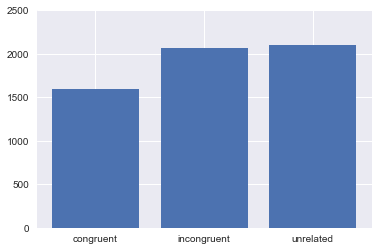

In [189]:
import seaborn as sns

def plot_v1(data):
    fig, ax = plt.subplots()
    ax.bar(np.arange(len(data)), data, align='center')
    ax.set_ylim(0, 2500)
    ax.set_xticks(np.arange(len(data)))
    ax.set_xticklabels([x for x in data.index])
    return fig, ax

plot_v1(means)